In [49]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing    import StandardScaler, OneHotEncoder, label_binarize
from sklearn.model_selection  import train_test_split, ParameterGrid
from sklearn.metrics          import classification_report, confusion_matrix, roc_curve, auc
from sklearn.decomposition    import PCA

import tensorflow as tf
from tensorflow.keras.models      import Sequential, Model
from tensorflow.keras.layers      import LSTM, Dense, Dropout
from tensorflow.keras.callbacks   import EarlyStopping

print("imports done")

imports done


In [50]:
# ─── 1) Load & flatten initial‐conditions (skipping the last sample) ──────────
data       = np.load("threebody_dataset2.npz")

# Drop the final “line” (sample) from each array:
masses     = data["masses"][:-1]           # now shape (N-1,3)
init_pos   = data["init_pos"][:-1]         # shape (N-1,3,2)
init_vel   = data["init_vel"][:-1]         # shape (N-1,3,2)
y_labels   = data["y"].astype(int)[:-1]    # shape (N-1,)

# Now reshape & stack as before
N_minus_1  = masses.shape[0]
pos_flat   = init_pos.reshape(N_minus_1, -1)   # → (N-1,6)
vel_flat   = init_vel.reshape(N_minus_1, -1)   # → (N-1,6)
X          = np.hstack([masses, pos_flat, vel_flat])  # → (N-1,15)



In [51]:
# ─── 2) Shuffle, scale, one‐hot ─────────────────────────────────────────────
rng    = np.random.RandomState(42)
perm   = rng.permutation(len(X))
X      = X[perm]
y_labels = y_labels[perm]

scaler = StandardScaler().fit(X)
X_scaled = scaler.transform(X)

ohe    = OneHotEncoder(sparse_output=False).fit(y_labels.reshape(-1,1))
Y      = ohe.transform(y_labels.reshape(-1,1))        # (N,3)


In [52]:
# ─── 3) 80/20 train/test split ───────────────────────────────────────────────
X_tr, X_te, Y_tr, Y_te, y_tr, y_te = train_test_split(
    X_scaled, Y, y_labels,
    test_size=0.2, random_state=42,
    stratify=y_labels
)



In [53]:
# ─── 4) Reshape for LSTM (samples, timesteps=1, features=15) ────────────────
X_tr_seq = X_tr.reshape(-1, 1, 15)
X_te_seq = X_te.reshape(-1, 1, 15)

In [54]:
# ─── 5) Further split train → train2/val for hyper‐param tuning ─────────────
X_train2, X_val, Y_train2, Y_val = train_test_split(
    X_tr_seq, Y_tr,
    test_size=0.2, random_state=42,
    stratify=y_tr
)

In [55]:
# ─── 6) Define hyperparameter grid ──────────────────────────────────────────
param_grid = {
    "units":         [32, 64, 128],
    "dropout":       [0.2, 0.5],
    "learning_rate": [1e-3, 1e-4],
    "batch_size":    [16, 32]
}

best_val_acc  = -np.inf
best_params   = None
best_model    = None



In [56]:
# ─── 7) Grid search ──────────────────────────────────────────────────────────
for params in ParameterGrid(param_grid):
    tf.keras.backend.clear_session()
    
    # Build model with these hyper-parameters
    model = Sequential([
        LSTM(params["units"], activation="tanh", input_shape=(1,15)),
        Dropout(params["dropout"]),
        Dense(3, activation="softmax")
    ])
    model.compile(
        loss="categorical_crossentropy",
        optimizer=tf.keras.optimizers.Adam(learning_rate=params["learning_rate"]),
        metrics=["accuracy"]
    )
    
    # Early stopping on val_loss
    es = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
    
    # Train on train2, validate on val
    history = model.fit(
        X_train2, Y_train2,
        validation_data=(X_val, Y_val),
        epochs=50,
        batch_size=params["batch_size"],
        callbacks=[es],
        verbose=0
    )
    
    # Evaluate on the validation set
    val_loss, val_acc = model.evaluate(X_val, Y_val, verbose=0)
    
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_params  = params
        best_model   = model

In [57]:
# ─── 8) Report best hyper‐parameters ─────────────────────────────────────────
print("Best hyper-parameters:", best_params)
print(f"Best validation accuracy: {best_val_acc*100:.2f}%\n")


Best hyper-parameters: {'batch_size': 16, 'dropout': 0.2, 'learning_rate': 0.001, 'units': 128}
Best validation accuracy: 95.83%



In [58]:
# ─── 8) Report best hyper‐parameters ─────────────────────────────────────────
print("Best hyper-parameters:", best_params)
print(f"Best validation accuracy: {best_val_acc*100:.2f}%\n")

# ─── 9) Final evaluation on held-out test set ───────────────────────────────
test_loss, test_acc = best_model.evaluate(X_te_seq, Y_te, verbose=0)
print(f"Test loss: {test_loss:.4f} — Test accuracy: {test_acc*100:.2f}%\n")

y_pred_probs = best_model.predict(X_te_seq)
y_pred       = np.argmax(y_pred_probs, axis=1)
y_true       = y_te

labels = [str(c) for c in ohe.categories_[0]]
print(classification_report(
    y_true, y_pred, target_names=labels
))

Best hyper-parameters: {'batch_size': 16, 'dropout': 0.2, 'learning_rate': 0.001, 'units': 128}
Best validation accuracy: 95.83%

Test loss: 0.1466 — Test accuracy: 93.33%



2/2 [==============================] - 0s 1ms/step
              precision    recall  f1-score   support

           0       0.90      0.90      0.90        20
           1       0.95      1.00      0.98        20
           2       0.95      0.90      0.92        20

    accuracy                           0.93        60
   macro avg       0.93      0.93      0.93        60
weighted avg       0.93      0.93      0.93        60



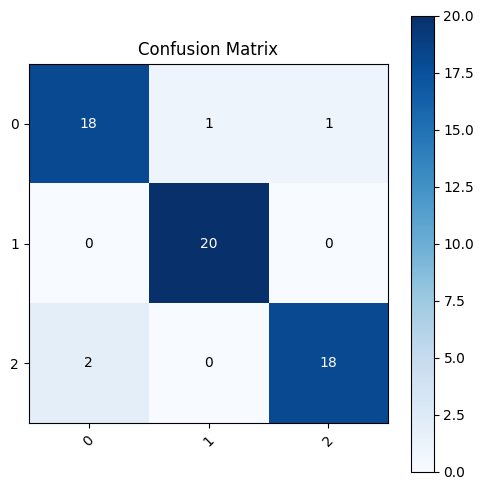

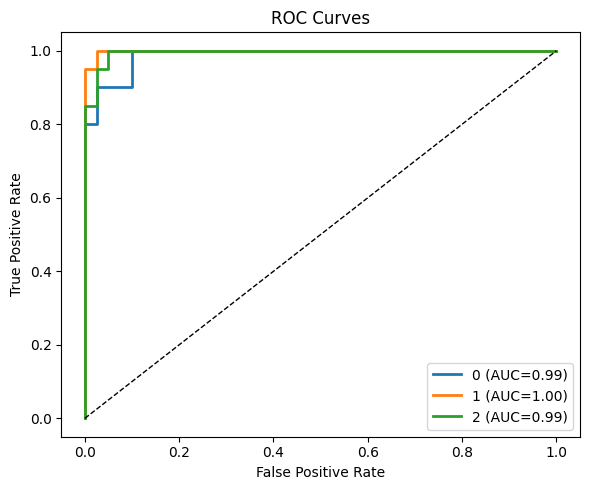

2/2 [==============================] - 0s 1ms/step


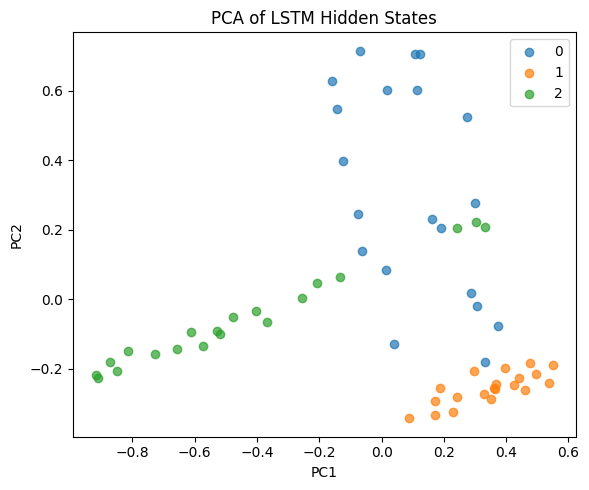

In [59]:
n_classes    = Y_te.shape[1]

# 10a) Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(5,5))
plt.title("Confusion Matrix")
plt.imshow(cm, interpolation='nearest', cmap='Blues')
plt.colorbar()
plt.xticks(np.arange(n_classes), labels, rotation=45)
plt.yticks(np.arange(n_classes), labels)
for i in range(n_classes):
    for j in range(n_classes):
        plt.text(j, i, cm[i, j], ha='center', va='center',
                 color='white' if cm[i,j] > cm.max()/2 else 'black')
plt.tight_layout()
plt.show()

# 10b) ROC curves (one-vs-rest)
y_test_bin = label_binarize(y_true, classes=list(range(n_classes)))
plt.figure(figsize=(6,5))
for i, lab in enumerate(labels):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_probs[:, i])
    roc_auc     = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f"{lab} (AUC={roc_auc:.2f})")
plt.plot([0,1], [0,1], 'k--', lw=1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

# 10c) PCA of LSTM hidden states
# Extract the 64-dim output of the LSTM layer for each test sample
feat_extractor = Model(inputs=model.input, outputs=model.layers[0].output)
states         = feat_extractor.predict(X_te_seq)    # (n_test, 64)

pca            = PCA(n_components=2, random_state=42)
pcs            = pca.fit_transform(states)

plt.figure(figsize=(6,5))
for idx, lab in enumerate(labels):
    mask = (y_true == idx)
    plt.scatter(pcs[mask,0], pcs[mask,1], alpha=0.7, label=lab)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA of LSTM Hidden States")
plt.legend()
plt.tight_layout()
plt.show()
